In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
import dataset_fctns, plotting
import copy

In [2]:
def phase_dependent_response(driver_values, t_dev, responses, thresholds):
    #Thresholds are the thresholds in development time where the different growth phases change
    #Responses are the response functions, index starting at 'before the first threshold'
    #driver values are the inputs to the response function
    #t_dev is the (cts) development time
    phase = np.digitize(t_dev, thresholds)
    response = np.zeros(driver_values.shape)
    for phase_index in range(len(responses)):
        response += (phase == phase_index)*responses[phase_index](driver_values) #First brackets indicates if we are at the right phase, second takes the response function for each phase
    return response

In [3]:
def get_nearest_elements(x, y, ds):
    #Interpolates the input array onto the (non-gridded e.g. phenology station) coordinates x and y.
    #Note hyras is not stored on the full grid, but on some kind of subset. Not quite sure how this works. Just got to hope the stations are in a hyras gridpoint.
    X_for_interp = xr.DataArray(x, dims="modelpoint")
    Y_for_interp = xr.DataArray(y, dims="modelpoint")
    return ds.interp(x=X_for_interp, y=Y_for_interp)#, kwargs={"fill_value": None})

In [4]:
def latlon_to_projection(x_coords, y_coords):
    proj_epsg = ccrs.epsg(3034)
    proj_latlon = ccrs.PlateCarree()
    points_epsg = proj_epsg.transform_points(proj_latlon, x_coords, y_coords)
    x_epsg = points_epsg[:, 0]
    y_epsg = points_epsg[:, 1]
    return x_epsg, y_epsg

In [22]:
def make_input_array(emergence_times, station_ids, reference_years, x_coords, y_coords, ds_driver):
    #Put in transforming to the right coords here x
    print('project to new coords')
    
    x_epsg, y_epsg = latlon_to_projection(x_coords, y_coords)
    print('interpolate driver to station locations')
    ds_driver_interp = get_nearest_elements(x_epsg, y_epsg, ds_driver)
    ds_driver_interp['emergence_dates'] = (("modelpoint"), emergence_times)
    ds_driver_interp['Stations_id'] = (("modelpoint"), station_ids)
    ds_driver_interp['Referenzjahr'] = (("modelpoint"), reference_years)
    ds_driver_interp = ds_driver_interp.assign_coords(modelpoint=np.arange(ds_driver_interp.sizes['modelpoint']))
    return ds_driver_interp#.dropna(dim='modelpoint')


In [148]:
def dev_under_response(response, ds_driver, driver_variable, maturity_t_dev):
    # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
    # Put in the date as (day, month, year)
    t_dev = np.zeros(ds_driver[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    #i_day = np.datetime64(f'{emergence_date[2]}-{str(emergence_date[1]).zfill(2)}-{str(emergence_date[0]).zfill(2)}')
    i_day = ds_driver['emergence_dates'].values.copy()
    i_day = i_day + np.timedelta64(12, 'h') #so that times are at midday rather than midnight
    time_indexer = xr.DataArray(i_day, dims=["modelpoint"])
    ds_driver.sel(time=time_indexer, method='nearest')
    day_count = 0
    while day_count < 365:#while np.sum(t_dev < maturity_t_dev) > 0.05*len(ds_driver['modelpoint']):
        print(day_count)
        #driver_values = ds_driver.sel(time=np.datetime_as_string(i_day, unit='D')).squeeze().values
        driver_values = ds_driver.sel(time=time_indexer, method='nearest')[driver_variable].values
        #print(t_dev[t_dev<maturity_t_dev])
        print(len(driver_values[t_dev<maturity_t_dev]))
        t_dev += response(driver_values, t_dev) #Rate of change of development stage
        dev_time_series.append(t_dev.copy())
        i_day += np.timedelta64(1,'D')
        day_count += 1
    return np.stack(dev_time_series)

In [7]:
def get_phase_dates(dev_time_series, thresholds):
    phase_dates_array = np.zeros((len(thresholds), dev_time_series.shape[1]))
    for obs_index in range(dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    return phase_dates_array

In [67]:
def get_modelled_dataset(ds_driver, phase_times, phase_list = []):
    reference_years = np.int64(ds_driver['Referenzjahr'].values)
    Stations_id = np.int64(ds_driver['Stations_id'].values)
    if len(phase_list) == 0:
        computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(phase_times.shape[0])]
    else:
        computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
    data_comparison = {'Stations_id': Stations_id,
                       'Referenzjahr': reference_years,
                       }
    ds_comparison = pd.DataFrame(data_comparison)
    for phase_index, phase in enumerate(computed_phases):
        ds_comparison[phase] = phase_times[phase_index, :]
    ds_comparison.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    return ds_comparison

# NOTE 
Issue with duplicates was just from quality checking

In [121]:
def get_observed_dataset(ds_verification, phase_list):
    observed_to_first_stage = dataset_fctns.time_stage_to_stage(phen_data_maize, 'beginning of emergence', phase_list[0]).dropna()
    ds_observed = pd.DataFrame({f'observed time emergence to {phase_list[0]}': observed_to_first_stage})
    for phase in phase_list[1:]:
        ds_observed[f'observed time emergence to {phase}'] = dataset_fctns.time_stage_to_stage(ds_verification, 'beginning of emergence', phase).dropna()
    return ds_observed

In [162]:
phen_data_maize = phen_data_maize.where(phen_data_maize['Qualitaetsniveau'] == 10).dropna()
ds_observed = get_observed_dataset(phen_data_maize, ['beginning of flowering', 'yellow ripeness'])

In [163]:
model_times = get_modelled_dataset(ds_driver, phase_times, phase_list=['beginning of flowering', 'yellow ripeness'])
full_dataset = pd.concat([model_times, ds_observed], axis = 1)

In [165]:
full_dataset.dropna()

modelled time emergence to beginning of flowering  \
Stations_id Referenzjahr                                                      
7504.0      2007.0                                                     82.0   
            2008.0                                                     81.0   
            2009.0                                                     80.0   
            2010.0                                                     74.0   
            2011.0                                                     86.0   
...                                                                     ...   
19755.0     2013.0                                                     75.0   
            2014.0                                                     80.0   
            2015.0                                                     79.0   
            2016.0                                                     76.0   
19914.0     2014.0                                                     81.0   

                          modelled time emergence to yellow ripeness  \
Stations_id Referenzjahr                                               
7504.0      2007.0                                             146.0   
            2008.0                                             141.0   
            2009.0                                             136.0   
            2010.0                                             146.0   
            2011.0                                             148.0   
...                                                              ...   
19755.0     2013.0                                             128.0   
            2014.0                                             135.0   
            2015.0                                             118.0   
            2016.0                                             119.0   
19914.0     2014.0                                             139.0   

                          observed time emergence to beginning of flowering  \
Stations_id Referenzjahr                                                      
7504.0      2007.0                                                     80.0   
            2008.0                                                     77.0   
            2009.0                                                     83.0   
            2010.0                                                     71.0   
            2011.0                                                     89.0   
...                                                                     ...   
19755.0     2013.0                                                     87.0   
            2014.0                                                    106.0   
            2015.0                                                    104.0   
            2016.0                                                    102.0   
19914.0     2014.0                                                     73.0   

                          observed time emergence to yellow ripeness  
Stations_id Referenzjahr                                              
7504.0      2007.0                                             145.0  
            2008.0                                             147.0  
            2009.0                                             126.0  
            2010.0                                             140.0  
            2011.0                                             147.0  
...                                                              ...  
19755.0     2013.0                                             166.0  
            2014.0                                             156.0  
            2015.0                                             163.0  
            2016.0                                             160.0  
19914.0     2014.0                                             126.0  

[7956 rows x 4 columns]

In [23]:
## READ IN DATA ##
ds_mean = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
phen_data_maize = dataset_fctns.read_phen_dataset("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", drop_list = ['Unnamed: 9'])
phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
station_data = station_data.drop('Unnamed: 12', axis = 1)
## READ IN DATA FOR PHASE NAMES IN ORDER ##
#print(phase_names['Phase_ID'])
phen_data_maize = dataset_fctns.add_locations(phen_data_maize, station_data)
phen_data_maize = dataset_fctns.phase_order_name(phen_data_maize, phase_names, [10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
phen_data_maize = dataset_fctns.order_phen_dataset(phen_data_maize)
#phen_data_wheat = dataset_fctns.add_locations(phen_data_wheat, station_data)
#phen_data_wheat = dataset_fctns.phase_order_name(phen_data_wheat, phase_names, [10, 12, 15, 18, 19, 21, 22, 23, 24, ])
#phen_data_wheat = dataset_fctns.order_phen_dataset(phen_data_wheat)
just_emergence_phen_data = phen_data_maize.where(phen_data_maize['Name of phase'] == 'beginning of emergence').dropna()
just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2005-01-01')).dropna()
emergences = just_emergence_phen_data['Eintrittsdatum'].values
station_ids = just_emergence_phen_data['Stations_id'].values
reference_years = just_emergence_phen_data['Referenzjahr'].values
x_coords = just_emergence_phen_data['lon'].values
y_coords = just_emergence_phen_data['lat'].values
ds_driver = make_input_array(emergences, station_ids, reference_years, x_coords, y_coords, ds_mean)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6496\585534896.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


project to new coords
interpolate driver to station locations


In [14]:
def Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
    f_T = np.nan_to_num(f_T)
    return f_T*(T >= T_min)*(T<= T_max)

In [15]:
def Trapezoid_Temp_response(T, T_min, T_opt1, T_opt2, T_max):
    pre_opt = (T>=T_min)*(T<=T_opt1)
    opt = (T>=T_opt1)*(T<=T_opt2)
    post_opt = (T>=T_opt2)*(T<=T_max)
    return pre_opt*(T - T_min)/(T_opt1 - T_min) + opt + post_opt*(T_max - T)/(T_max - T_opt2)

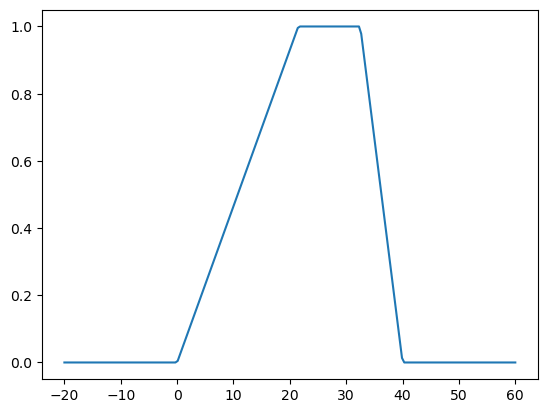

In [17]:
x = np.linspace(-20, 60, 200)
#y = Wang_Engel_Temp_response(x, 0, 27.5, 40)
y = Trapezoid_Temp_response(x, 0, 21.5, 32.5, 40)
plt.plot(x, y)

In [161]:
resps = [lambda x: Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: Wang_Engel_Temp_response(x, 0, 33, 44)]
thresholds = [45, 65]
ds_driver = ds_driver.dropna(dim='modelpoint')
prediction = dev_under_response(lambda x, y: phase_dependent_response(x, y, resps, thresholds), 
                                ds_driver, 'tas', thresholds[-1])
phase_times = get_phase_dates(prediction, thresholds)

0
12899
1
12899
2
12899
3
12899
4
12899
5
12899
6
12899
7
12899
8
12899
9
12899
10
12899
11
12899
12
12899
13
12899
14
12899
15
12899
16
12899
17
12899
18
12899
19
12899
20
12899
21
12899
22
12899
23
12899
24
12899
25
12899
26
12899
27
12899
28
12899
29
12899
30
12899
31
12899
32
12899
33
12899
34
12899
35
12899
36
12899
37
12899
38
12899
39
12899
40
12899
41
12899
42
12899
43
12899
44
12899
45
12899
46
12899
47
12899
48
12899
49
12899
50
12899
51
12899
52
12899
53
12899
54


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6496\2397755492.py:3: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


12899
55
12899
56
12899
57
12899
58
12899
59
12899
60
12899
61
12899
62
12899
63
12899
64
12899
65
12899
66
12899
67
12899
68
12899
69
12899
70
12899
71
12899
72
12899
73
12899
74
12899
75
12899
76
12899
77
12899
78
12899
79
12899
80
12899
81
12899
82
12899
83
12899
84
12899
85
12899
86
12899
87
12899
88
12898
89
12893
90
12887
91
12883
92
12875
93
12850
94
12817
95
12787
96
12749
97
12692
98
12614
99
12549
100
12478
101
12415
102
12344
103
12259
104
12168
105
12061
106
11938
107
11772
108
11617
109
11443
110
11248
111
11036
112
10832
113
10593
114
10343
115
10063
116
9769
117
9476
118
9117
119
8752
120
8425
121
8087
122
7770
123
7420
124
7109
125
6800
126
6526
127
6222
128
5933
129
5672
130
5422
131
5169
132
4945
133
4723
134
4529
135
4337
136
4157
137
3969
138
3818
139
3665
140
3525
141
3406
142
3297
143
3179
144
3071
145
2973
146
2883
147
2792
148
2714
149
2630
150
2568
151
2504
152
2451
153
2386
154
2334
155
2287
156
2249
157
2215
158
2180
159
2149
160
2117
161
2087
162
2068
163
20

Make a dataset with predicted flowering times and actual flowering times, predicted maturity times and actual maturity times. Then get RMSE. Make a clause that if a phase takes longer than 300 then 'not achieved'.

Index result dataset by 'Stations_id' and 'Referenzjahr'.
Then make a new dataset with the existing functions.

In [ ]:
## Test that indexing is working well ##
i_day = ds_driver['emergence_dates'].values.copy()
for obs_index, day in enumerate(i_day):
    print(day, ds_driver['tas'].sel(time=day, modelpoint=obs_index).values)
time_indexer = xr.DataArray(i_day, dims=["modelpoint"])
ds_driver.sel(time=time_indexer, method='nearest')